# Motivation

In order to predict the income of pupils, I used the pupils dataset.

# Data Preprocessing

In [1]:
import pandas as pd
data = pd.read_csv('Pupils.csv')
data.head()

,Name,Age,Country,Height,Weight,Avg Grades,income,house rooms,family persons
0,adar,6,SP,113,30,70,16700,7,6
1,agam,6,GR,172,71,92,9200,5,4
2,avi,7,ISR,143,58,82,12000,3,7
3,dani,7,US,160,70,90,15000,4,4
4,dina,7,ISR,110,26,64,10000,6,8


In [2]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 9 columns):
Name              30 non-null object
Age               30 non-null int64
Country           30 non-null object
Height            30 non-null int64
Weight            30 non-null int64
Avg Grades        30 non-null int64
income            30 non-null int64
house rooms       30 non-null int64
family persons    30 non-null int64
dtypes: int64(7), object(2)
memory usage: 2.2+ KB


In [3]:
data.shape

(30, 9)

I now use the describe() method to show the summary statistics of the numeric variables.

In [4]:
data.describe()

,Age,Height,Weight,Avg Grades,income,house rooms,family persons
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,9.433333,137.266667,51.500000,80.500000,20096.666667,4.366667,5.833333
std,2.207875,26.286136,18.104581,7.942683,11943.270601,1.629117,1.743626
min,6.000000,90.000000,26.000000,64.000000,7600.000000,2.000000,3.000000
25%,8.000000,113.500000,34.000000,74.000000,11175.000000,3.000000,4.250000
50%,9.000000,132.000000,53.000000,82.000000,17650.000000,4.500000,6.000000
75%,11.000000,158.000000,65.500000,85.750000,23750.000000,5.750000,7.000000
max,14.000000,192.000000,90.000000,94.000000,54100.000000,7.000000,10.000000


The count, mean, min and max rows are self-explanatory. The std shows the standard deviation, and the 25%, 50% and 75% rows show the corresponding percentiles

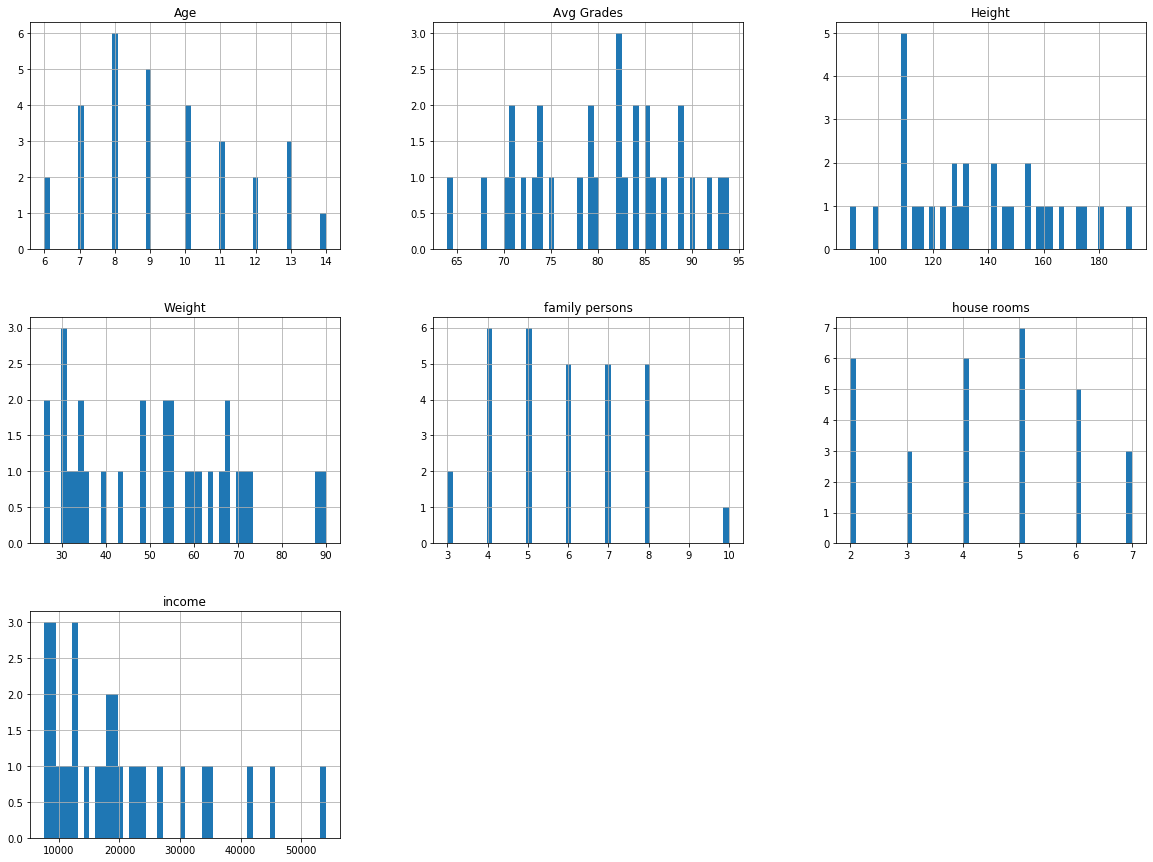

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
data.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

Some of the histograms are a little bit right skewed, but this is not abnormal.

Let’s create a scatter plot with Height and Weight to visualize the data:

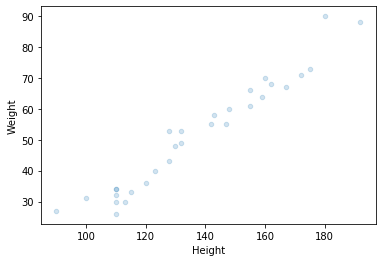

In [6]:
data.plot(kind="scatter", x="Height", y="Weight", alpha=0.2)
plt.savefig('map1.png')

Now let’s color code from the most excellent to the least excellent sizes:

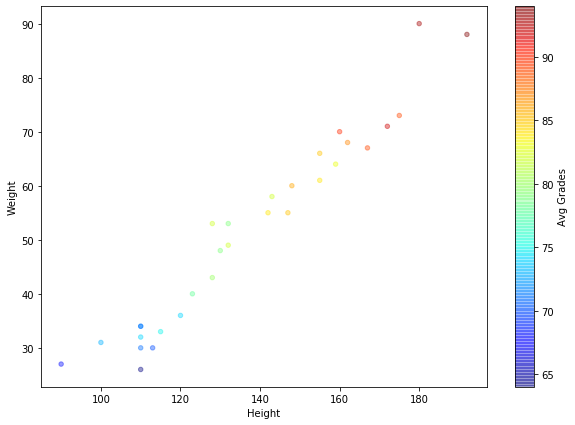

In [7]:
data.plot(kind="scatter", x="Height", y="Weight", alpha=0.4, figsize=(10,7),
    c="Avg Grades", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

The variable we are going to predict is the “Avg Grades”. So let’s look at how much each independent variable correlates with this dependent variable.

In [8]:
corr_matrix = data.corr()
corr_matrix["Avg Grades"].sort_values(ascending=False)

Avg Grades        1.000000
Weight            0.959074
Height            0.944887
Age               0.150426
income            0.145275
house rooms      -0.065290
family persons   -0.212886
Name: Avg Grades, dtype: float64

The average grade tends to increase when the weight and the height grades go up. You can see a negative correlation between the family persons and the average grade. And finally, coefficients close to zero indicate that there is no linear correlation.

We are now going to visualize the correlation between variables by using Pandas’ scatter_matrix function. We will just focus on a few promising variables, that seem the most correlated with the income.

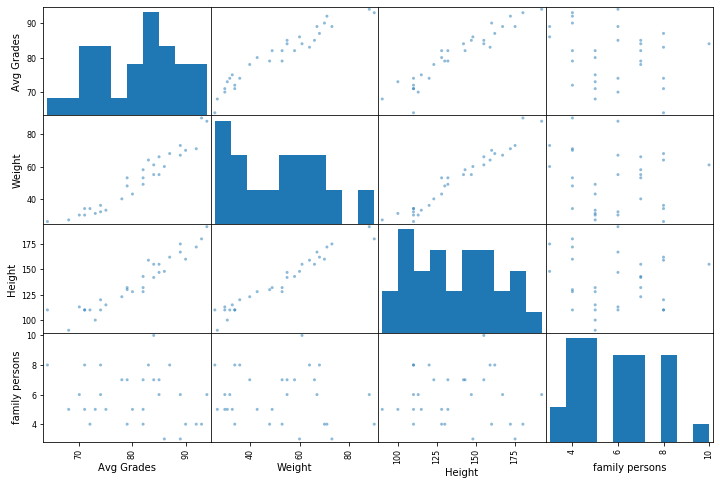

In [9]:
from pandas.plotting import scatter_matrix
attributes = ["Avg Grades", "Weight", "Height", "family persons"]
scatter_matrix(data[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

The most promising variable for predicting the average grade is the weight, so let’s zoom in on their correlation scatter plot.

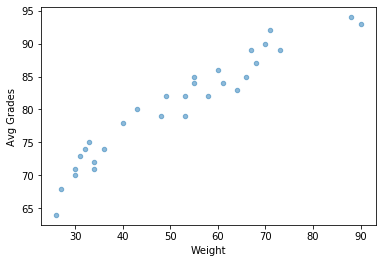

In [10]:
data.plot(kind="scatter", x="Weight", y="Avg Grades", alpha=0.5)
plt.savefig('scatter.png')

The correlation is indeed very strong; you can see the upward trend and that the points are not too dispersed.

Because each pupil has different age and each country has different average grades, what we really need is the average per age. So, we add a new variable “average_per_age”. We then check to see how much this new independent variable correlates with the average grades.

In [11]:
data['average_per_age'] = data['Avg Grades']/data['Age']
corr_matrix = data.corr()
corr_matrix["Avg Grades"].sort_values(ascending=False)

Avg Grades         1.000000
Weight             0.959074
Height             0.944887
average_per_age    0.287499
Age                0.150426
income             0.145275
house rooms       -0.065290
family persons    -0.212886
Name: Avg Grades, dtype: float64

Unortunately, the new average_per_age variable shows only a very small positive correlation with the average grades. But we still need this variable for grouping countries.

There are 6 countries in the data, and we are going to group them.

In [12]:
len(data['Country'].value_counts())

6

The following steps cluster the countries into three groups: 1. low average; 2. high average low income; 3. high average high income.

In [13]:
freq = data.groupby('Country').mean()['income']
mean = data.groupby('Country').mean()['average_per_age']
cluster = pd.concat([freq, mean], axis=1)
cluster['Country'] = cluster.index
cluster.columns = ['freq', 'average_per_age','Country']
cluster.describe()

,freq,average_per_age
count,6.000000,6.000000
mean,20395.833333,8.818364
std,3334.644534,1.451251
min,16550.000000,6.985577
25%,18393.750000,7.921360
50%,19737.500000,8.756610
75%,21793.750000,9.546733
max,25925.000000,10.958333


These are the low average countries:

In [14]:
cluster1 = cluster[cluster.average_per_age < 8.75]
cluster1.index

Index(['EN', 'FR', 'SP'], dtype='object', name='Country')

These are the high average and low income countries:

In [15]:
cluster_temp = cluster[cluster.average_per_age >= 8.75]
cluster2 = cluster_temp[cluster_temp.freq < 19737.5]
cluster2.index

Index(['GR', 'ISR'], dtype='object', name='Country')

These are the high average and high income countries:

In [16]:
cluster3 = cluster_temp[cluster_temp.freq >= 19737.5]
cluster3.index

Index(['US'], dtype='object', name='Country')

We add a group column based on the clusters:

In [17]:
def get_group(x):
    if x in cluster1.index:
        return 'low_average'
    elif x in cluster2.index:
        return 'high_average_low_income'
    else:
        return 'high_average_high_income'
data['group'] = data.Country.apply(get_group)

After performing the above pre-processing, we do not need the following column anymore: “Name", "Country" and "average_per_age". so, we drop them from our analysis.

In [18]:
data.drop(['Name', 'average_per_age', 'Country'], axis=1, inplace=True)
data.head()

,Age,Height,Weight,Avg Grades,income,house rooms,family persons,group
0,6,113,30,70,16700,7,6,low_average
1,6,172,71,92,9200,5,4,high_average_low_income
2,7,143,58,82,12000,3,7,high_average_low_income
3,7,160,70,90,15000,4,4,high_average_high_income
4,7,110,26,64,10000,6,8,high_average_low_income


Our data looks perfect!

But before we build the model, we need to create dummy variables for the categorical variable: “group”.

In [19]:
data = data[['Age', 'Height', 'Weight', 'Avg Grades', 'income', 'house rooms', 'family persons', 'group']]
data.head()

,Age,Height,Weight,Avg Grades,income,house rooms,family persons,group
0,6,113,30,70,16700,7,6,low_average
1,6,172,71,92,9200,5,4,high_average_low_income
2,7,143,58,82,12000,3,7,high_average_low_income
3,7,160,70,90,15000,4,4,high_average_high_income
4,7,110,26,64,10000,6,8,high_average_low_income


In [20]:
X = data[['Age', 'Height', 'Weight', 'income', 'house rooms', 'family persons', 'group']]
Y = data['Avg Grades']

n = pd.get_dummies(data.group)
X = pd.concat([X, n], axis=1)

drops = ['group']
X.drop(drops, inplace=True, axis=1)

X.head()

,Age,Height,Weight,income,house rooms,family persons,high_average_high_income,high_average_low_income,low_average
0,6,113,30,16700,7,6,0,0,1
1,6,172,71,9200,5,4,0,1,0
2,7,143,58,12000,3,7,0,1,0
3,7,160,70,15000,4,4,1,0,0
4,7,110,26,10000,6,8,0,1,0


This is what our data looks like after creating dummy variables

# Train and Build a Linear Regression Model

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Done! We now have a working Linear Regression model.

Calculate R squared:

In [22]:
y_pred = regressor.predict(X_test)
print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))

Linear Regression R squared": 0.8519


So, in our model, 85.19% of the variability in Y can be explained using X. This is exciting.

Calculate root-mean-square error (RMSE)

In [23]:
import numpy as np
from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 2.8211


Our model was able to predict the average of every pupil in the test set within 2.8211 of the real average.

Calculate mean absolute error (MAE):

In [24]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(y_pred, y_test)
print('Linear Regression MAE: %.4f' % lin_mae)

Linear Regression MAE: 2.1445


# Random Forest

Let’s try a more complex model to see whether results can be improved — the RandomForestRegressor:

In [25]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [26]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.9247


In [27]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 2.0119


Much better! Let’s try one more.

# Gradient boosting

In [28]:
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor
model = ensemble.GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
print('Gradient Boosting R squared": %.4f' % model.score(X_test, y_test))

Gradient Boosting R squared": 0.9085


In [30]:
y_pred = model.predict(X_test)
model_mse = mean_squared_error(y_pred, y_test)
model_rmse = np.sqrt(model_mse)
print('Gradient Boosting RMSE: %.4f' % model_rmse)

Gradient Boosting RMSE: 2.2178


The random forest has the best results we have so far, so, I would consider this is our final model.

# Feature Importance

We have used 9 features (variables) in our model. Let’s find out which features are important and vice versa.

In [31]:
feature_labels = np.array(['Age', 'Height', 'Weight', 'income', 'house rooms', 'family persons',
       'high_average_high_income', 'high_average_low_income', 'low_average'],)
importance = forest_reg.feature_importances_
feature_indexes_by_importance = importance.argsort()[::-1]
for index in feature_indexes_by_importance:
    print('{}-{:.2f}%'.format(feature_labels[index], (importance[index] *100.0)))

Weight-50.25%
Height-43.03%
house rooms-2.11%
Age-1.28%
income-1.26%
family persons-1.03%
low_average-0.57%
high_average_low_income-0.24%
high_average_high_income-0.23%


# Real time predictions

Now our model has been built, let me use it for real time predictions.

In [32]:
X.columns

Index(['Age', 'Height', 'Weight', 'income', 'house rooms', 'family persons',
       'high_average_high_income', 'high_average_low_income', 'low_average'],
      dtype='object')

In [33]:
a = int(input("Please enter the pupil's age:"))
b = int(input("Please enter the pupil's height:"))
c = int(input("Please enter the pupil's weight:"))
d = int(input("Please enter the pupil's income:"))
e = int(input("Please enter the pupil's house rooms:"))
f = int(input("Please enter the pupil's family persons:"))
g = int(input("Does the pupil live in a high_average_high_income country, such as 'US' (1 if yes, 0 otherwise):"))
h = int(input("Does the pupil live in a high_average_low_income country, such as 'GR', 'ISR' (1 if yes, 0 otherwise):"))
i = int(input("Does the pupil live in a low_average country, such as 'EN', 'FR', 'SP' (1 if yes, 0 otherwise):"))
new_data = np.array([a,b,c,d,e,f,g,h,i]).reshape(1,-1)
new_pred=regressor.predict(new_data)

print("\033[1m The estimated income for that pupil is : $ \033[1m ",float(new_pred[0]))

Please enter the pupil's age:6
Please enter the pupil's height:113
Please enter the pupil's weight:30
Please enter the pupil's income:16700
Please enter the pupil's house rooms:7
Please enter the pupil's family persons:6
Does the pupil live in a high_average_high_income country, such as 'US' (1 if yes, 0 otherwise):0
Does the pupil live in a high_average_low_income country, such as 'GR', 'ISR' (1 if yes, 0 otherwise):0
Does the pupil live in a low_average country, such as 'EN', 'FR', 'SP' (1 if yes, 0 otherwise):1
 The estimated income for that pupil is : $   71.427555500257


# Your Turn!

Hopefully, this post gives you a good idea of what a machine learning regression project looks like. As you can see, much of the work is in the data wrangling and the preparation steps, and these procedures consume most of the time spent on machine learning.

Now it’s time to get out there and start exploring and cleaning your data. Try two or three algorithms, and let me know how it goes.

I would be pleased to receive feedback or questions on any of the above.